In [1]:
import pandas as pd
# Load the CSV file (update the path to your actual file)
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np


In [2]:
df = pd.read_csv("spam_ham_dataset.csv", encoding='latin-1')  # 'latin-1' works for special characters
train_x,test_x = train_test_split(df,test_size=0.2,random_state=7)
spam_count = defaultdict(int)
ham_count = defaultdict(int)
print(df.head)

<bound method NDFrame.head of       Unnamed: 0 label                                               text  \
0            605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1           2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2           3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3           4685  spam  Subject: photoshop , windows , office . cheap ...   
4           2030   ham  Subject: re : indian springs\r\nthis deal is t...   
...          ...   ...                                                ...   
5166        1518   ham  Subject: put the 10 on the ft\r\nthe transport...   
5167         404   ham  Subject: 3 / 4 / 2000 and following noms\r\nhp...   
5168        2933   ham  Subject: calpine daily gas nomination\r\n>\r\n...   
5169        1409   ham  Subject: industrial worksheets for august 2000...   
5170        4807  spam  Subject: important online banking alert\r\ndea...   

      label_num  
0             0  
1        

In [3]:
def split_cust(email,freq):
    words=[]
    i=0
    j=0
    count=0
    while (i<len(email)):
        while((i<len(email))and(email[i]!=' ' and email[i]!='\n' and email[i]!='\t' and email[i]!=',' and email[i]!='-' and email[i]!=':' and email[i]!='.' )):
            i+=1
        word = email[j:i]
        while((i<len(email))and(email[i]==' ' or email[i]=='\n' or email[i]=='\t' or email[i]==',' or email[i]=='-' or email[i]==':' or email[i]=='.')):
            i+=1
        j=i
        #print(word)
        words.append(word)
        freq[word]+=1
        count+=1
    return words,count


In [4]:
spam_mail = train_x[ train_x['label']=='spam']['text']
spam_mail = list(spam_mail)

ham_mail = train_x[ train_x['label']=='ham']['text']
ham_mail = list(ham_mail)

prob_spam = len(spam_mail)/len(df)
prob_ham = len(ham_mail)/len(df)

In [5]:
words_spam=set()
spam_word_count=0
for s in spam_mail:
    word,count=(split_cust(s,spam_count))
    words_spam = words_spam | set(word)
    spam_word_count+=count
words_ham=set()
ham_word_count =0
for s in ham_mail:
    word,count=(split_cust(s,ham_count))
    words_ham|=set(word)
    ham_word_count+=count

 


finding probability of occurance of word

In [6]:
prob_word_spam = defaultdict(float)
for w in words_spam:
    prob_word_spam[w] = (spam_count[w]+1)/(spam_word_count+len(words_spam))
prob_word_ham = defaultdict(float)
for w in words_ham:
    prob_word_ham[w]= (ham_count[w]+1)/(ham_word_count+len(words_ham))


# testing phase

In [7]:
def predict (s):
    
    freq_count = defaultdict(int)
    words,count = split_cust(s,freq_count)
    p_spam =1
    p_ham = 1
    for w in words:
        if(prob_word_spam[w]==0):
            prob_word_spam[w]=1/(spam_word_count+len(words_spam))
        p_spam *=prob_word_spam[w]
        if(prob_word_ham[w]==0):
            prob_word_ham[w]=1/(ham_word_count+len(words_ham))
        p_ham *= prob_word_ham[w]
    p_spam*=prob_spam
    p_ham *= prob_ham
    if p_spam>p_ham:
        return 1
    return 0


In [8]:
predict_label=[]
for s in test_x['text']:
    predict_label.append(predict(s))
print(predict_label[:-5])
print(test_x['label'])
label = list(test_x['label_num'])

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
print(len(predict_label))
print(len(test_x))

1035
1035


In [10]:
accuracy = np.array(predict_label)^ np.array(label)
accuracy_score = np.sum(accuracy)
print(accuracy_score)
accuracy_percentage = (1035-accuracy_score)/1035
accuracy_score*=100
print(accuracy_percentage)

173
0.8328502415458937


In [11]:
from sklearn.metrics import classification_report

print(classification_report(np.array(predict_label),np.array(label)))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       905
           1       0.43      0.98      0.59       130

    accuracy                           0.83      1035
   macro avg       0.71      0.89      0.74      1035
weighted avg       0.92      0.83      0.86      1035



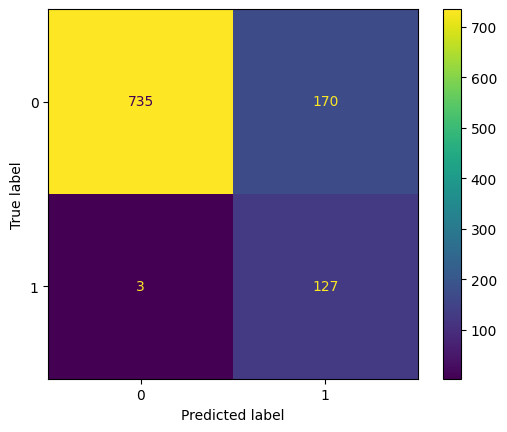

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(np.array(predict_label),np.array(label))
ConfusionMatrixDisplay(cm).plot()